In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


- season: 1 - весна, 2 - лето, 3 - осень, 4 - зима
- yr: 0 - 2011, 1 - 2012
- mnth: от 1 до 12 (соответственно январь---декабрь)
- holiday: 0 - нет праздника, 1 - есть праздник
- weekday: от 0 до 6 (соответственно понедельник---воскресенье)
- workingday: 0 - нерабочий день, 1 - рабочий день
- workthersit: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
- temp: температура в Цельсиях
- atemp: температура по ощущениям в Цельсиях
- hum: влажность
- windspeed(mph): скорость ветра в милях в час
- windspeed(ms): скорость ветра в метрах в секунду
- cnt: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

# EDA

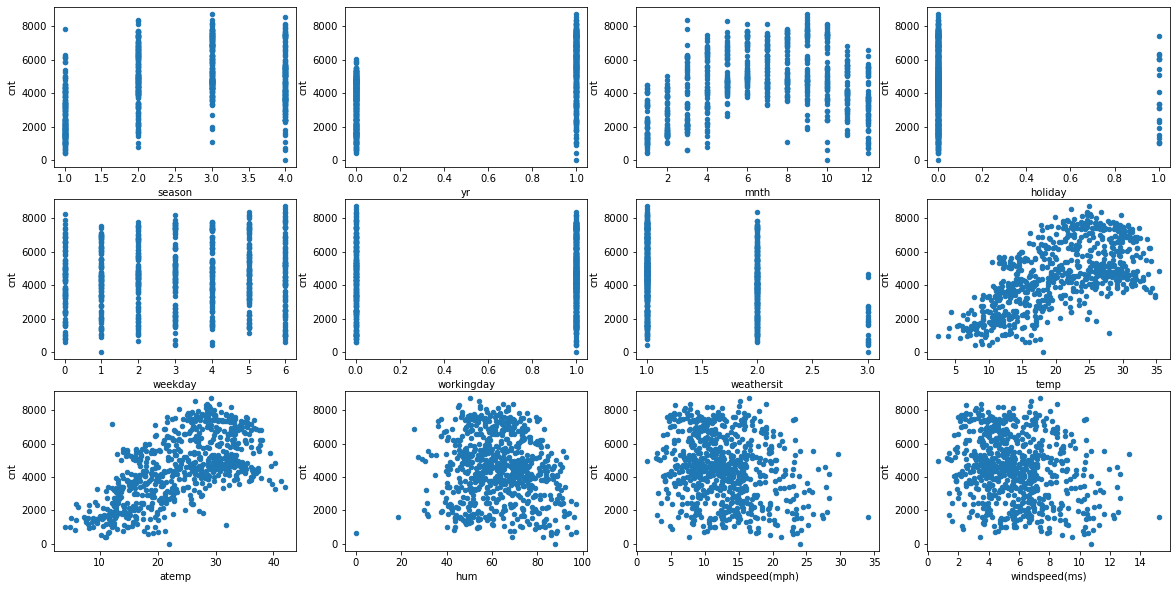

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])
#    df.boxplot(feature, "cnt", ax=axes[idx // 4, idx % 4])

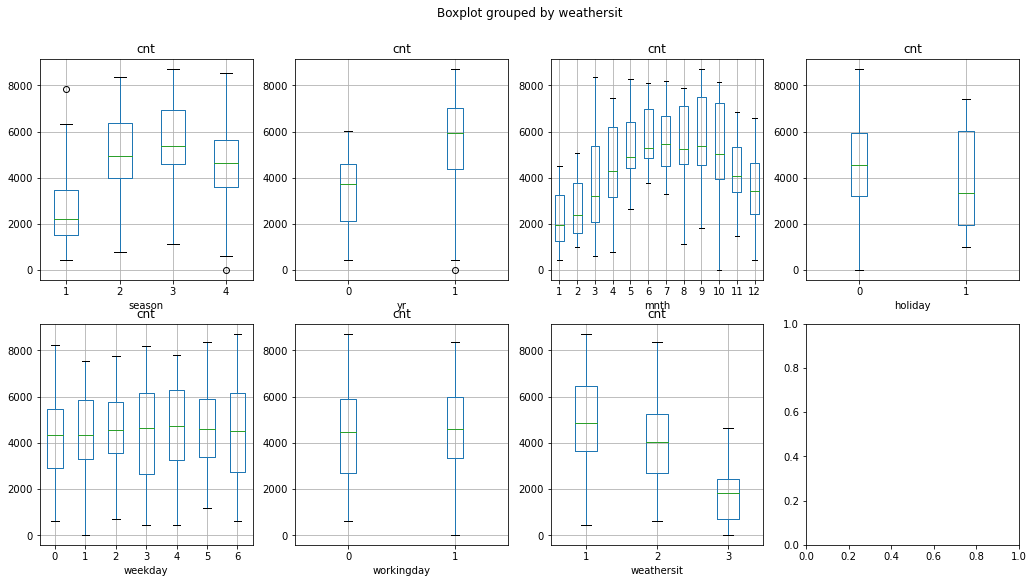

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17, 9))
for idx, feature in enumerate(df.columns[:7]):
    df.boxplot('cnt', feature, ax=axes[idx // 4, idx % 4])

## Корреляция Пирсона

### Корреляция признаков с target

In [5]:
df.iloc[:,0:12].corrwith(df["cnt"])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

### Корреляция вещественных признаков друг с другом

In [6]:
df.iloc[:,7:13].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Мультикоррелиарность наблюдается у:
-    temp и temp   
-    windspeed(mph) и windspeed(ms)

In [7]:
# Видим, что необходима нормировка
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

In [8]:
X = scale(df[df.columns[:-1]])
print(X[:2])
y = df["cnt"]
print(y[:2])

[[-1.34821315 -1.00136893 -1.60016072 -0.171981    1.49880863 -1.47122472
   1.11042659 -0.82666213 -0.67994602  1.25017133 -0.38789169 -0.38789169]
 [-1.34821315 -1.00136893 -1.60016072 -0.171981   -1.49607732 -1.47122472
   1.11042659 -0.72109471 -0.74065231  0.47911298  0.74960172  0.74960172]]
0    985
1    801
Name: cnt, dtype: int64


In [9]:
regr = LinearRegression()

regr.fit(X, y)

print('Coefficients: \n', regr.coef_, "\n")
print('Feature:        Weight:')

for feature, coeff in zip(df.columns,regr.coef_):
    st1 = '              '
    diff = st1[:len(st1)-len(feature)]
    print(feature, diff, coeff)

Coefficients: 
 [ 5.70864422e+02  1.02196721e+03 -1.41302311e+02 -8.67590916e+01
  1.37224008e+02  5.63910736e+01 -3.30231397e+02  3.67476265e+02
  5.85553428e+02 -1.45610157e+02  1.24575891e+13 -1.24575891e+13] 

Feature:        Weight:
season          570.8644224537686
yr              1021.9672124104904
mnth            -141.3023112779559
holiday         -86.75909162158396
weekday         137.2240078828474
workingday      56.39107362238852
weathersit      -330.2313967512377
temp            367.47626544907115
atemp           585.5534282408429
hum             -145.61015712185292
windspeed(mph)  12457589061017.207
windspeed(ms)   -12457589061215.668


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Решение проблемы мультиколлинеарности состоит в регуляризации линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$.

In [10]:
regrL = Lasso()
regrL.fit(X, y)

regrR = Ridge()
regrR.fit(X, y)

print('Lasso_coef:             Ridge_coef')
for feature, coeff in zip(regrL.coef_, regrR.coef_):
    st1 = '            '
    diff = st1[:len(st1)-len(str(feature))]
    print(feature, diff, coeff)

Lasso_coef:             Ridge_coef
560.2416160308859         563.0645722520143
1019.4634940657198        1018.9483787875288
-128.73062703678679       -131.87332028247283
-86.15278133371103        -86.74609799709248
137.34789390496314        138.00511117871912
55.2123706413566          55.903110375064706
-332.36985696234836       -332.3497884990733
376.3632362096955         386.4578891919046
576.5307935045541         566.3470470600707
-144.12915500348612       -145.07132729867283
-197.13968940249666       -99.25944108186312
-2.8039136891624038e-08   -99.25944115426942


В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Всё из-за ромбообразных линий уровня L1-нормы.

## Подбор коэффициента регуляризации $\alpha$

Пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$

In [11]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1])) # в нашем случае 10х12

for i, a in enumerate(alphas):
    
    regrL = Lasso(alpha=a)
    regrL.fit(X, y)
    weights=regrL.coef_
    
    for j, weight in enumerate(weights): # [w1, w2, w3 ... w10], [0 ... 0]
        coefs_lasso[i,j]=weight

        
for i, a in enumerate(alphas):
    
    regrR = Ridge(alpha=a)
    regrR.fit(X, y)
    weights=regrR.coef_
    
    for j, weight in enumerate(weights):
        coefs_ridge[i,j]=weight

In [12]:
coefs_lasso[:2]

array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80391369e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29791861e-08]])

Text(0.5, 1.0, 'Ridge')

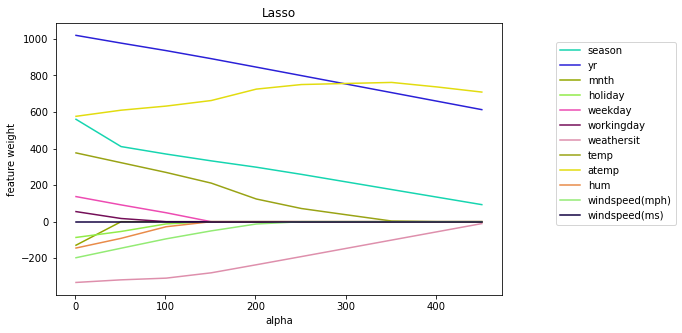

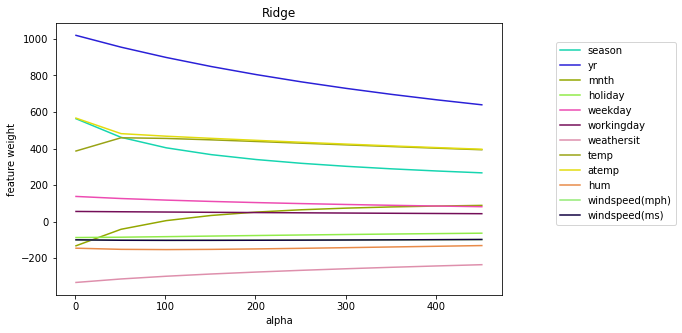

In [13]:
plt.figure(figsize=(8, 5))

colors=[]
for feature in df.columns:
    colors.append(np.random.rand(3))

for coef, feature, color in zip(coefs_lasso.T, df.columns, colors):
    plt.plot(alphas, coef, label=feature, color=color)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature, color in zip(coefs_ridge.T, df.columns,colors):
    plt.plot(alphas, coef, label=feature, color=color)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

## Cross - validation

Best alpha= 25
Best_MSE= 625694.386921865


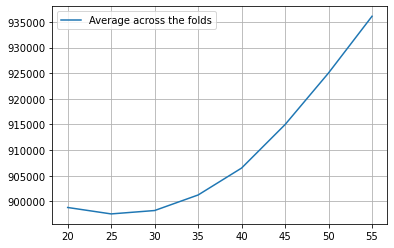

In [106]:
alphas = np.arange(20, 60, 5)

model = LassoCV(alphas=alphas, cv=3).fit(X, y) # cv - кол-во фолдов


plt.plot(model.alphas_, model.mse_path_.mean(axis=1), 
         label='Average across the folds')
plt.grid(True)
plt.legend(loc='upper left')

print("Best alpha=", model.alpha_)
print('Best_MSE=', model.mse_path_.min())

Лучший альфа - 25

In [108]:
model.mse_path_.mean(axis=1).min()

897544.4682913992

In [15]:
model.mse_path_

array([[ 725158.52081265,  643655.08654327, 1439568.87486911],
       [ 726035.7168456 ,  636759.80483737, 1412377.53197715],
       [ 727879.27024326,  630136.92141826, 1386930.40136398],
       [ 730659.82573569,  625694.38692187, 1363132.85932001],
       [ 734377.4993472 ,  628868.11026264, 1340472.03030517],
       [ 739226.8897273 ,  635827.14820152, 1319563.9853892 ],
       [ 745689.09153854,  646535.39100783, 1300408.92232783],
       [ 752407.00282011,  660989.93258807, 1283004.57516668]])

In [16]:
model.mse_path_.mean(axis=1)

array([936127.49407501, 925057.68455337, 914982.19767517, 906495.69065919,
       901239.213305  , 898206.00777267, 897544.4682914 , 898800.50352495])

In [17]:
print("alpha=", model.alpha_)

regrL = Lasso(alpha=model.alpha_)

# Train the model using the sets
regrL.fit(X, y)

# The coefficients
weights=regrL.coef_

print('\nFeature:  Weight:')
      
for feature, coeff in zip(df.columns,regr.coef_.T):
    print(feature, coeff)

print()
print('Ошибки')    
model.mse_path_

alpha= 25

Feature:  Weight:
season 570.8644224537686
yr 1021.9672124104904
mnth -141.3023112779559
holiday -86.75909162158396
weekday 137.2240078828474
workingday 56.39107362238852
weathersit -330.2313967512377
temp 367.47626544907115
atemp 585.5534282408429
hum -145.61015712185292
windspeed(mph) 12457589061017.207
windspeed(ms) -12457589061215.668

Ошибки


array([[ 725158.52081265,  643655.08654327, 1439568.87486911],
       [ 726035.7168456 ,  636759.80483737, 1412377.53197715],
       [ 727879.27024326,  630136.92141826, 1386930.40136398],
       [ 730659.82573569,  625694.38692187, 1363132.85932001],
       [ 734377.4993472 ,  628868.11026264, 1340472.03030517],
       [ 739226.8897273 ,  635827.14820152, 1319563.9853892 ],
       [ 745689.09153854,  646535.39100783, 1300408.92232783],
       [ 752407.00282011,  660989.93258807, 1283004.57516668]])

6 различных alpha по 3 фолда

alphas_min_columns= [55 40 20]


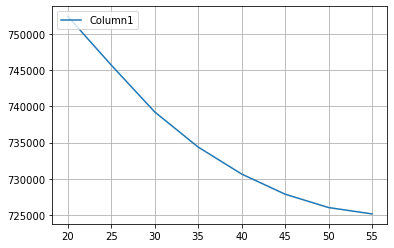

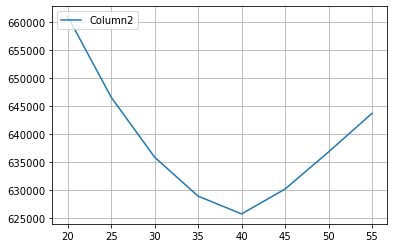

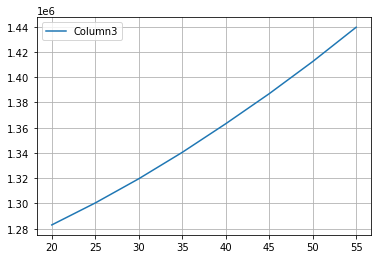

In [18]:
################################
# Графики MSE по каждому фолду.
################################

index_mins = model.mse_path_.argmin(axis=0)
print("alphas_min_columns=", model.alphas_[index_mins])

for i in range(3):
    plt.plot(model.alphas_, model.mse_path_[:,i], label='Column'+ str(i+1))
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

# Control predict

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [117]:
regr = LinearRegression()
regr.fit(X_train, y_train)

pred = regr.predict(X_test)

print(pred[:50])
print(y_test[:50].values)

print('Наш алгоритм в среднем ошибается на',round(mean_absolute_error(y_test, pred), 0), 'велосипедов')

[4150.6205246  2651.59493511 4820.83072603 4385.24593844 6106.8740205
 4846.09601492 5746.29239045 3415.76793049 2185.12810855 5341.55977761
 2475.61144203 1613.4895903   718.36011325 2568.02030067 6726.91089303
 2918.9801691  5343.21610648 5612.65624344 3400.434556   5066.17107531
 1897.39377319 7247.29107302 4791.75633805 3122.66234248 4890.76873979
 4495.08487947 7624.56032119 4718.61974908 3957.57289596 3023.90261396
 1391.39558042 3409.25228548 2108.99096496 3505.21338402 8026.46110896
 4557.1444579  1212.78672862 3167.82084858 7623.69439525 4573.12106723
 2758.12121888 6381.20109631 8342.86435181 5115.8219576  5313.59317071
 5266.56696677 6782.33475571 3893.68890825 5227.44938032 5206.56504533]
[3830 2114 3915 4322 6591 5204 5323 3351 3068 4972 3351 1977  822 2485
 7736 2368 5515 6572 4511 4359 1851 7335 4758 2689 4966 4118 6824 4375
 3389 2475  754 3523 1683 1749 6241 4570 1416 3368 6591 4023 4553 7424
 4840 5728 5202 4717 7338 4035 2277 4866]
Наш алгоритм в среднем ошибается на

In [118]:
regr.coef_

array([ 5.58466995e+02,  1.02990942e+03, -1.02796600e+02, -5.14544782e+01,
        1.61159990e+02,  4.44910369e+01, -3.15544560e+02,  2.68658306e+02,
        6.69856845e+02, -1.88662900e+02,  1.72906276e+11, -1.72906276e+11])

In [119]:

regrL = Lasso(alpha=model.alpha_)
regrL.fit(X_train, y_train)

pred = regrL.predict(X_test)

print(pred[:50])
print(y_test[:50].values)

print('Наш алгоритм в среднем ошибается на',round(mean_absolute_error(y_test, pred), 0), 'велосипедов')

[4112.52952305 2990.33703088 4809.70102459 4383.42095696 6152.9669548
 4803.76318811 5654.9852283  3660.21070034 2473.52099493 5390.41344742
 2563.99812068 1673.39962576  818.74229288 2904.44753727 6652.84272795
 2851.45232047 5217.44335957 5590.89057263 3467.35197794 5100.80054291
 1952.68340717 7106.67699771 4794.0238909  3193.3817669  4916.17991373
 4482.27013365 7594.48692917 4666.99669585 3980.21163596 3017.93318765
 1786.86808732 3423.4989339  2110.87655437 3839.47634119 7888.60660904
 4516.75098381 1201.08776598 3315.15404539 7506.04659607 4529.77075786
 2874.73962705 6322.80512896 8224.07816007 5140.26688247 5230.50519951
 5264.20409109 6698.16947276 3884.09872816 5224.51011243 5164.89685022]
[3830 2114 3915 4322 6591 5204 5323 3351 3068 4972 3351 1977  822 2485
 7736 2368 5515 6572 4511 4359 1851 7335 4758 2689 4966 4118 6824 4375
 3389 2475  754 3523 1683 1749 6241 4570 1416 3368 6591 4023 4553 7424
 4840 5728 5202 4717 7338 4035 2277 4866]
Наш алгоритм в среднем ошибается на

In [120]:
regrL.coef_

array([ 450.32894499, 1009.37758511,   -0.        ,  -32.02944643,
        140.76267132,   23.20208539, -309.26576864,  257.35182474,
        669.98228747, -162.36699013, -143.85729754,   -0.        ])

l1:  0.0
Best alpha= 0.03
Best MSE= 899270.7258609046

l1:  0.1
Best alpha= 0.04
Best MSE= 899108.5249511916

l1:  0.2
Best alpha= 0.04
Best MSE= 899097.8125457452

l1:  0.30000000000000004
Best alpha= 0.05
Best MSE= 899058.7001747707

l1:  0.4
Best alpha= 0.060000000000000005
Best MSE= 899098.3662353255

l1:  0.5
Best alpha= 0.06999999999999999
Best MSE= 899052.4144369675

l1:  0.6000000000000001
Best alpha= 0.08
Best MSE= 899078.3950891658

l1:  0.7000000000000001
Best alpha= 0.09
Best MSE= 899701.7519138601

l1:  0.8
Best alpha= 0.09
Best MSE= 902942.1943637716

l1:  0.9
Best alpha= 0.09
Best MSE= 909577.0954161258

l1:  1.0
Best alpha= 0.09
Best MSE= 922850.6715142857



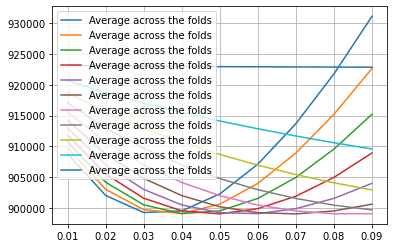

In [121]:
alphas = np.arange(0.01, 0.1, 0.01)
l1_list = np.arange(0, 1.1, 0.1)

for l1 in l1_list:
    model = ElasticNetCV(alphas=alphas, l1_ratio = l1, cv=3).fit(X, y) # cv - кол-во фолдов


    plt.plot(model.alphas_, model.mse_path_.mean(axis=1), 
             label='Average across the folds')
    plt.grid(True)
    plt.legend(loc='upper left')

    
    print('l1: ',l1)
    print("Best alpha=", model.alpha_)
    print("Best MSE=", model.mse_path_.mean(axis=1).min())
    print()

In [122]:

Elastic = ElasticNet(alpha=0.07, l1_ratio = 0.5)
Elastic.fit(X_train, y_train)

pred = Elastic.predict(X_test)

print(pred[:50])
print(y_test[:50].values)

print('Наш алгоритм в среднем ошибается на',round(mean_absolute_error(y_test, pred), 0), 'велосипедов')

[4137.98261249 2820.48616662 4862.37299883 4367.1227078  6080.50198527
 4879.770498   5693.1173919  3473.35711829 2390.81021904 5343.67411513
 2532.51600634 1691.41750957  804.98913743 2748.50543976 6707.63996945
 2919.25535079 5341.30483931 5555.62966968 3441.97222722 5040.45772357
 1973.68590099 7171.36733725 4818.72561254 3147.93428086 4926.21111492
 4499.56304509 7544.63272315 4692.48528009 3969.97516595 3054.26111445
 1617.18726845 3443.34695013 2148.47100784 3659.3481607  7956.24792124
 4562.49074748 1269.37827525 3195.51449203 7553.01616181 4521.00817988
 2815.53246319 6346.38977652 8258.84684332 5077.84651028 5300.63480078
 5228.99702251 6741.39973638 3915.07793339 5203.50711751 5222.99143429]
[3830 2114 3915 4322 6591 5204 5323 3351 3068 4972 3351 1977  822 2485
 7736 2368 5515 6572 4511 4359 1851 7335 4758 2689 4966 4118 6824 4375
 3389 2475  754 3523 1683 1749 6241 4570 1416 3368 6591 4023 4553 7424
 4840 5728 5202 4717 7338 4035 2277 4866]
Наш алгоритм в среднем ошибается н

In [123]:

Elastic = ElasticNet(alpha=0.3, l1_ratio = 1)
Elastic.fit(X_train, y_train)

pred = Elastic.predict(X_test)

print(pred[:50])
print(y_test[:50].values)

print('Наш алгоритм в среднем ошибается на',round(mean_absolute_error(y_test, pred), 0), 'велосипедов')

[4150.46932343 2654.53323446 4820.78049751 4384.94317161 6107.46144603
 4845.84776884 5745.25074319 3419.23332114 2190.26479253 5342.87291244
 2476.71555236 1614.03149155  719.37480237 2573.65589545 6726.54792234
 2917.64008883 5342.07268612 5611.82143404 3401.21522978 5066.28855315
 1898.13936229 7245.75261195 4791.81888375 3123.87595383 4891.43663313
 4495.091408   7623.80225064 4717.56697987 3957.73039325 3023.32999635
 1398.32958649 3409.16209104 2109.29237949 3509.89859259 8024.89519538
 4556.54230865 1212.31959669 3170.17322982 7622.5264407  4572.05403335
 2759.45252736 6380.78873173 8341.12655349 5115.99315332 5312.47459497
 5266.07198058 6781.42117464 3893.48753282 5229.28046242 5206.10796123]
[3830 2114 3915 4322 6591 5204 5323 3351 3068 4972 3351 1977  822 2485
 7736 2368 5515 6572 4511 4359 1851 7335 4758 2689 4966 4118 6824 4375
 3389 2475  754 3523 1683 1749 6241 4570 1416 3368 6591 4023 4553 7424
 4840 5728 5202 4717 7338 4035 2277 4866]
Наш алгоритм в среднем ошибается н